In [97]:
# !pip install openpyxl
# !pip install cartopy
# !pip install folium
# !pip install plotly
# !pip install nbformat
# !pip install nbformat --upgrade
# print(nbformat.__version__)
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.1/37.1 MB 12.0 MB/s eta 0:00:0000:0100:01


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px
import nbformat
import random
from scipy.optimize import curve_fit

In [4]:
df = pd.read_excel("./data/Pittsburgh_AMS_Mobile_2016_2017.xlsx")

In [5]:
df.shape

(16392, 47)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16392 entries, 0 to 16391
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OBJECTID           16392 non-null  int64         
 1   datetime           16392 non-null  datetime64[ns]
 2   run_index          16392 non-null  int64         
 3   Longitude          16392 non-null  float64       
 4   Latitude           16392 non-null  float64       
 5   Elevation          16089 non-null  float64       
 6   hour               16392 non-null  int64         
 7   CO2                13287 non-null  float64       
 8   CO                 13377 non-null  float64       
 9   NO                 13377 non-null  float64       
 10  NO2                13377 non-null  float64       
 11  NOx                13377 non-null  float64       
 12  matlab_date        16392 non-null  int64         
 13  month              16392 non-null  int64         
 14  PageNa

In [7]:
# Drop rows with missing NO2 since that is our target variable
df_NO2 = df.dropna(subset=['NO2'])

In [8]:
df_NO2.shape

(13377, 47)

In [9]:
df_NO2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13377 entries, 0 to 16377
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OBJECTID           13377 non-null  int64         
 1   datetime           13377 non-null  datetime64[ns]
 2   run_index          13377 non-null  int64         
 3   Longitude          13377 non-null  float64       
 4   Latitude           13377 non-null  float64       
 5   Elevation          13074 non-null  float64       
 6   hour               13377 non-null  int64         
 7   CO2                13287 non-null  float64       
 8   CO                 13377 non-null  float64       
 9   NO                 13377 non-null  float64       
 10  NO2                13377 non-null  float64       
 11  NOx                13377 non-null  float64       
 12  matlab_date        13377 non-null  int64         
 13  month              13377 non-null  int64         
 14  PageName   

### datetime eda

In [10]:
# Check if there is duplicate datetime - no duplicate
datetime_duplicates = df_NO2[df_NO2.duplicated(subset=['datetime'], keep=False)]
datetime_duplicates

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,NH4RB,NH4Local,BC,BCRB,BCLocal,weight,site,period,season,type


In [11]:
# Splite the datetime into date and time, and extract year from date, count the number of records for each year
df_NO2["date"] = df_NO2["datetime"].dt.date
df_NO2["time"] = df_NO2["datetime"].dt.time
df_NO2["year"] = df_NO2["datetime"].dt.year
df_NO2["day"] = df_NO2["datetime"].dt.day

/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_76390/1221647113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["date"] = df_NO2["datetime"].dt.date
/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_76390/1221647113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["time"] = df_NO2["datetime"].dt.time
/var/folders/jt/9jtp_3t15h70m1pgcfrm_h900000gn/T/ipykernel_76390/1221647113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [12]:
df_NO2["year"].value_counts()

year
2017    8255
2016    5122
Name: count, dtype: int64

In [13]:
df_NO2.groupby(["year", "month"]).size()

year  month
2016  8        1144
      9        1254
      11       2724
2017  1        2664
      2        5591
dtype: int64

### Location eda

In [14]:
# Check if there is duplicate location - there are duplicates
location_duplicates = df_NO2[df_NO2.duplicated(subset=["Longitude", "Latitude"], keep=False)]
location_duplicates.groupby(["Longitude", "Latitude"]).size()

Longitude   Latitude 
-80.174872  40.366092    3
-80.171097  40.374954    3
-80.171014  40.375293    2
-80.171012  40.375292    8
-80.164268  40.379745    2
                        ..
-79.927246  40.462968    2
            40.462970    2
-79.920841  40.475663    2
-79.917734  40.478751    2
-79.885895  40.539102    4
Length: 151, dtype: int64

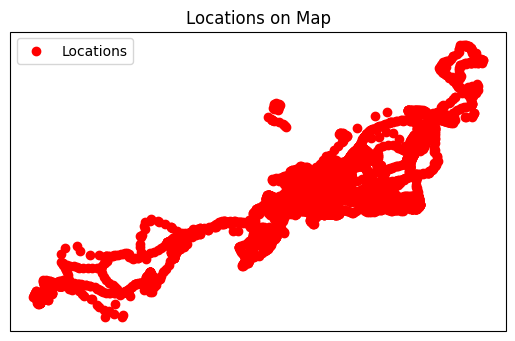

In [15]:
# Create a map using PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot points on the map
ax.scatter(df_NO2["Longitude"], df_NO2["Latitude"], color='red', marker='o', label='Locations')

# Add additional map features (e.g., coastlines)
ax.coastlines()

# Add labels and legend
ax.set_title('Locations on Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Display the map
plt.show()

In [16]:
mapbox_api_token = 'pk.eyJ1IjoibWFyY2lhYWFtYSIsImEiOiJjbG9vbW05ZDIwMWhiMmtvZG1ldG55cnJ5In0.8vFy9eh9od6Su_RMcCs4IQ'

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_NO2, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color_continuous_scale=color_scale,
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [17]:
BBox = (df_NO2.Longitude.min(), df_NO2.Longitude.max(),      
         df_NO2.Latitude.min(), df_NO2.Latitude.max())
print(BBox)

(-80.17995679, -79.8753362, 40.35625813, 40.54018586)


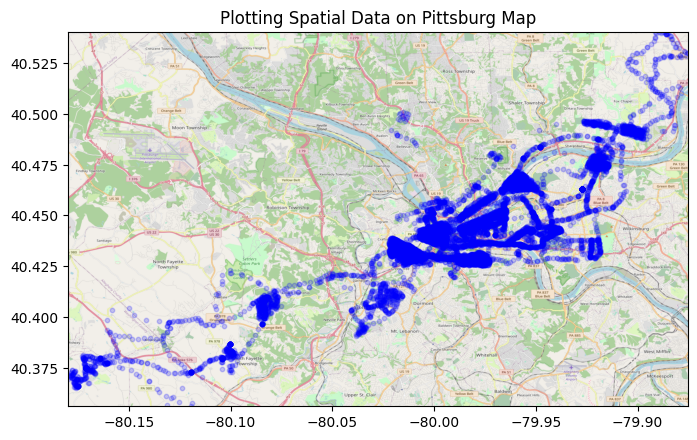

In [18]:
pittsburg_map = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_NO2.Longitude, df_NO2.Latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Pittsburg Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(pittsburg_map, zorder=0, extent = BBox, aspect= 'equal')

### Periodic pattern explorition

#### Daily pattern

In [19]:
df_testtrain = df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]

In [37]:
daily_NO2 = df_testtrain.groupby(['year', 'month', 'day']).agg({'NO2': list, 'time': list}).reset_index()

In [38]:
daily_NO2

,year,month,day,NO2,time
0,2016,8,8,"[16.36271475, 13.75216667, 14.86651897, 9.6491...","[09:55:00, 09:56:02, 09:56:59, 09:58:01, 09:59..."
1,2016,8,9,"[-9.069262903, -9.116518333, -8.809322951, -8....","[03:07:59, 03:09:01, 03:10:00, 03:11:01, 03:12..."
2,2016,8,11,"[-6.270311864, -6.096198413, -5.92671, -5.5022...","[03:40:59, 03:42:01, 03:43:00, 03:44:01, 03:44..."
3,2016,8,12,"[-4.137595238, -4.501166667, -4.653906557, -4....","[03:10:01, 03:11:00, 03:12:00, 03:13:00, 03:14..."
4,2016,8,15,"[-4.5978, -4.161147619, -4.017589831, 1.157774...","[17:09:59, 17:11:01, 17:11:59, 17:13:01, 17:14..."
5,2016,8,17,"[-4.434341667, -4.689796825, -4.837294915, -4....","[17:07:00, 17:08:02, 17:09:00, 17:10:01, 17:11..."
6,2016,9,13,"[5.119584127, 5.167116129, 5.63892931, 5.47132...","[18:33:01, 18:34:02, 18:34:59, 18:36:01, 18:37..."
7,2016,9,15,"[4.778098333, 4.592757377, 4.457638333, 4.2378...","[06:02:00, 06:03:00, 06:03:59, 06:04:59, 06:06..."
8,2016,9,20,"[4.046434426, 3.865424194, 3.557131148, 3.4145...","[17:28:00, 17:29:01, 17:30:01, 17:31:00, 17:32..."
9,2016,9,22,"[0.010986885, -0.004790164, -0.088759016, -0.1...","[13:18:03, 13:19:03, 13:20:03, 13:21:03, 13:22..."


In [43]:
random_idx = random.sample(range(0, len(daily_NO2)), 10)

In [44]:
random_idx

[1, 23, 5, 27, 20, 16, 21, 3, 22, 11]

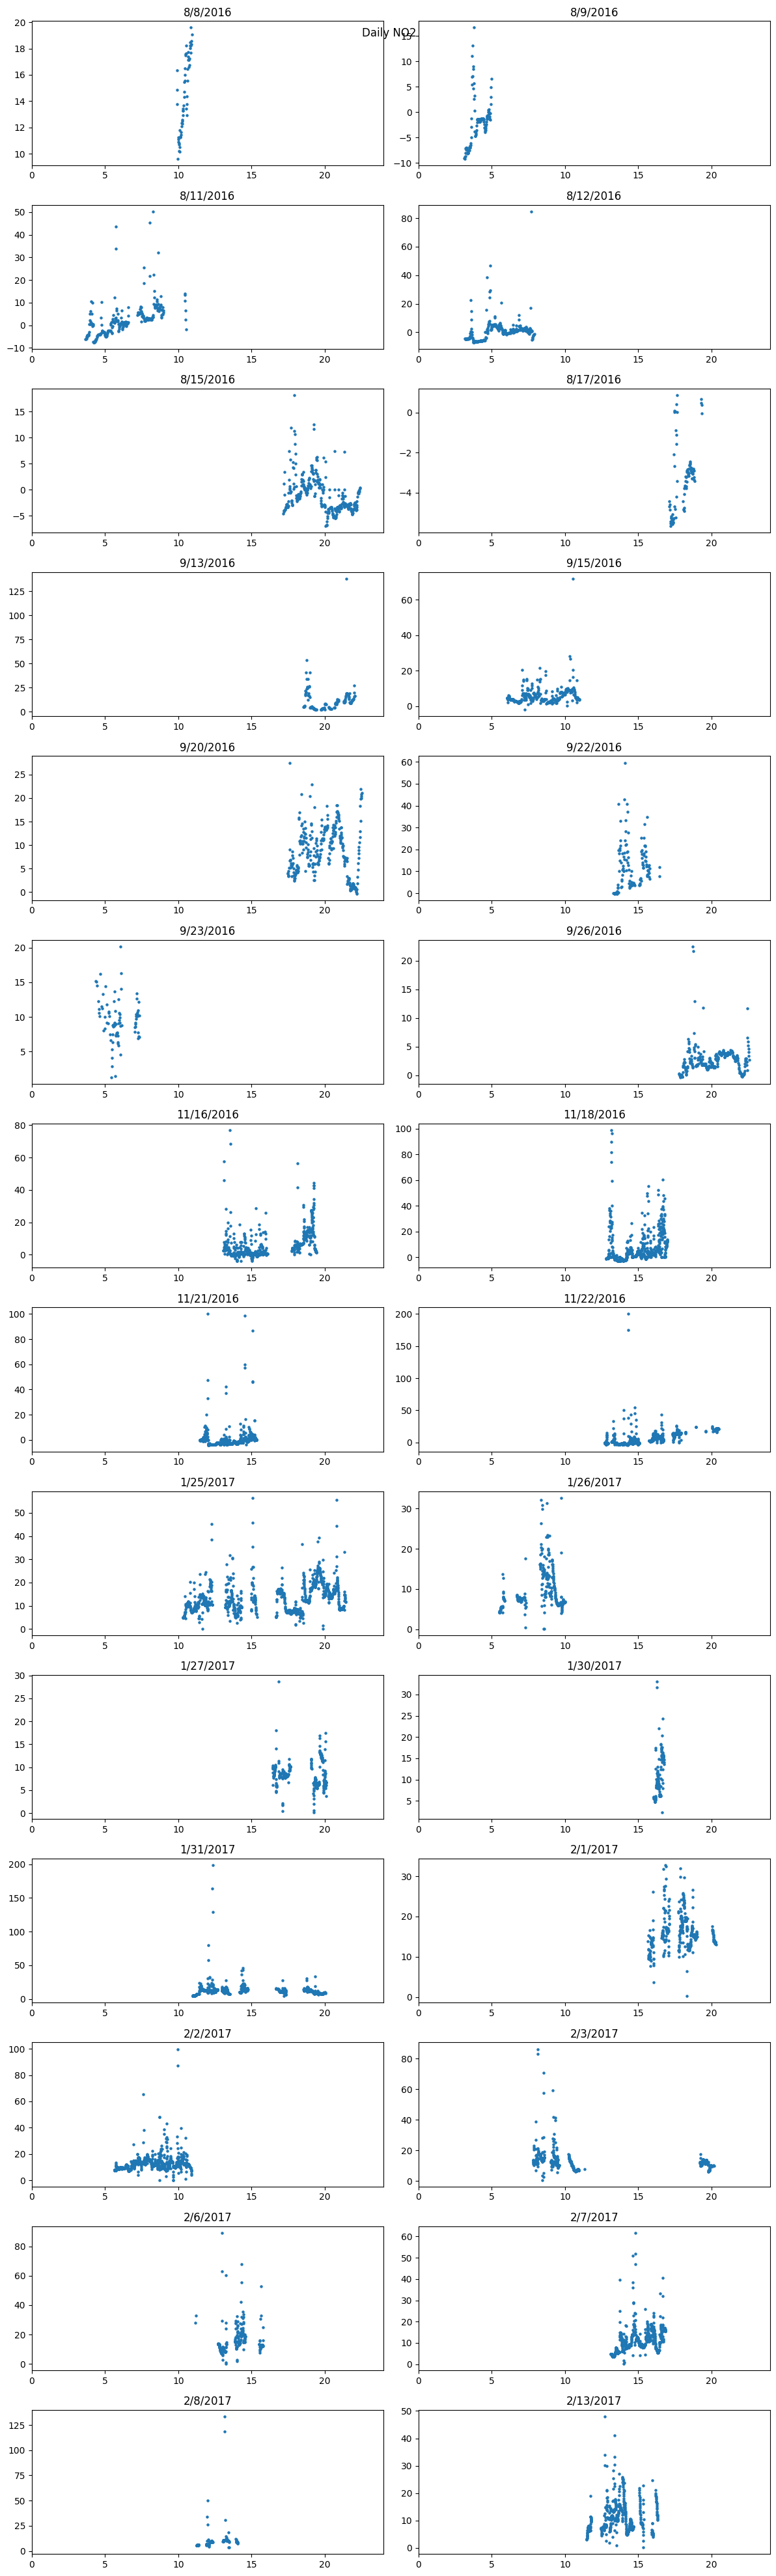

In [82]:
# Daily NO2 visualization for each of the 29 days

fig, axs = plt.subplots(14, 2, figsize=(12, 40))
fig.suptitle("Daily NO2")

for i in range(14):
    for j in range(2):
        subplot_index = i * 2 + j
        idx_row = daily_NO2.iloc[subplot_index]
        timestamps = idx_row['time']
        times_numeric = [t.hour + t.minute / 60 for t in timestamps]
        NO2 = idx_row['NO2']
        ax = axs[i, j]
        ax.scatter(times_numeric, NO2, s=5)
        ax.set_title(f"{idx_row['month']}/{idx_row['day']}/{idx_row['year']}")
        ax.set_xlim(0, 24)
        # ax.set_ylim(y_min, y_max)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [83]:
negative_count = (df_testtrain['NO2'] < 0).sum()
negative_count
negative_count = (df_testtrain['NO2'] > -100).sum()
negative_count
1544/11845

0.13035035880118193

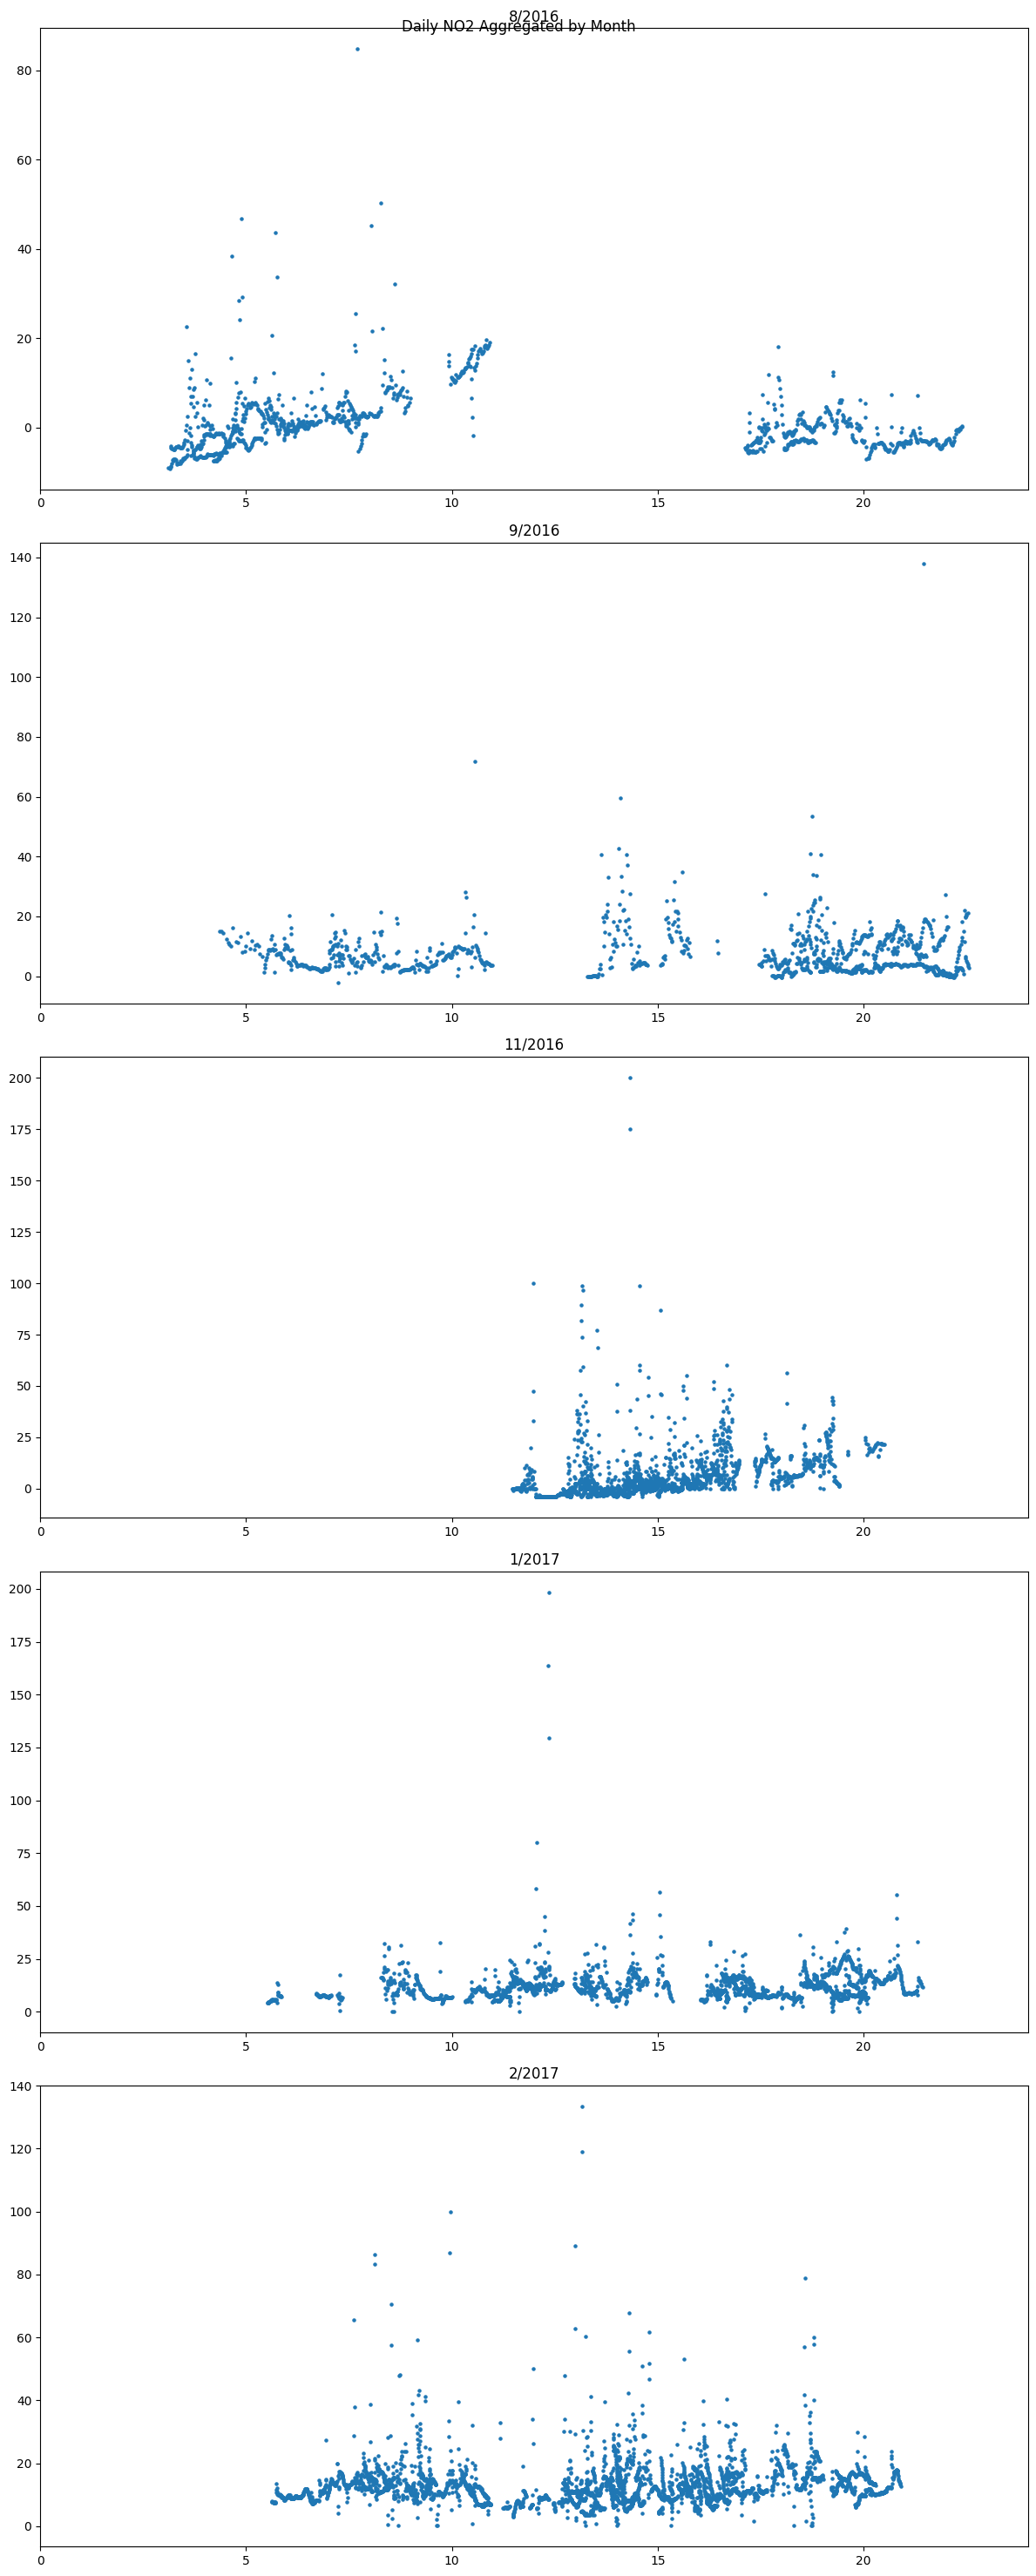

In [84]:
# Daily NO2 visualization aggregated by month
daily_NO2_agg_by_month = daily_NO2.groupby(['year', 'month']).agg({'NO2': list, 'time': list}).reset_index()

fig, axs = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle("Daily NO2 Aggregated by Month")

for i in range(5):
    idx_row = daily_NO2_agg_by_month.iloc[i]
    timestamps_lists = idx_row['time']
    timestamps = [item for sublist in timestamps_lists for item in sublist]
    times_numeric = [t.hour + t.minute / 60 for t in timestamps]
    NO2_lists = idx_row['NO2']
    NO2 = [item for sublist in NO2_lists for item in sublist]
    ax = axs[i]
    ax.scatter(times_numeric, NO2, s=5)
    ax.set_title(f"{idx_row['month']}/{idx_row['year']}")
    ax.set_xlim(0, 24)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

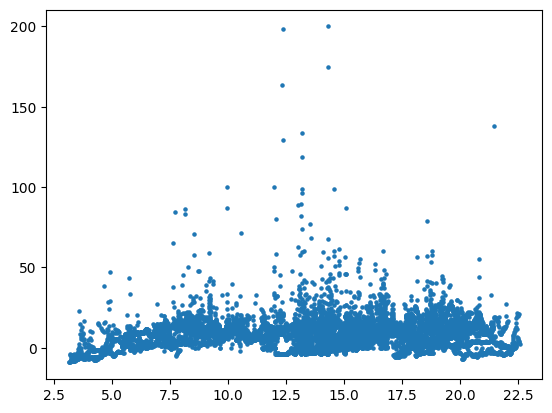

In [87]:
# Daily NO2 visualization aggregated across all dates
flattened_NO2 = daily_NO2['NO2'].explode().tolist()
flattened_time = daily_NO2['time'].explode().tolist()

flattened_times_numeric = [t.hour + t.minute / 60 for t in flattened_time]
plt.scatter(flattened_times_numeric, flattened_NO2, s=5)

In [93]:
# Filter out some outliers
flattened_time = np.array(flattened_time)
filtered_NO2 = [value for value in flattened_NO2 if value < 40]
filtered_idx = [index for index, value in enumerate(flattened_NO2) if value < 40]
filtered_time = flattened_time[filtered_idx]

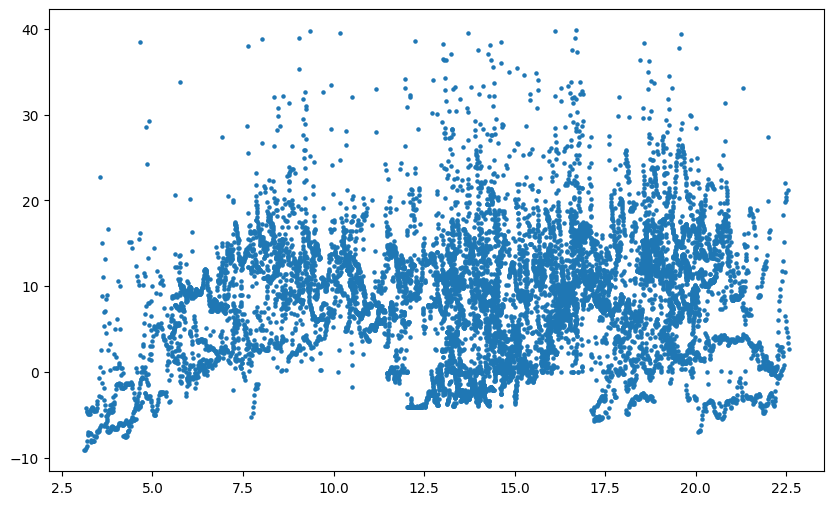

In [95]:
plt.figure(figsize=(10, 6))
filtered_time_numeric = [t.hour + t.minute / 60 for t in filtered_time]
plt.scatter(filtered_time_numeric, filtered_NO2, s=5)

MSE of hand-tuned period function: 101.12478462924972


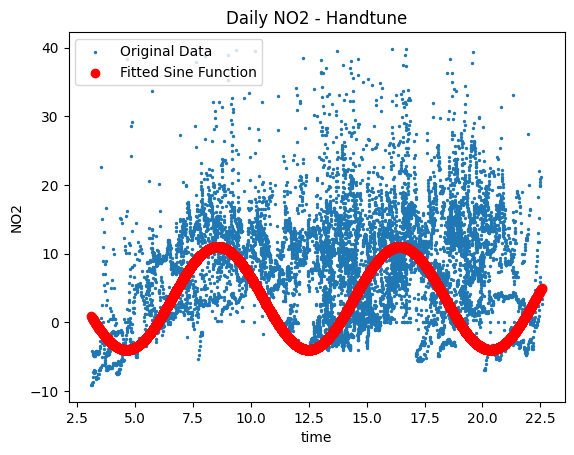

In [164]:
# HANDTUNE - Define the sine function to fit - Use this for initialization for fit_curve
def daily_trend(t, amplitude, frequency, phase, offset):
    t = np.array(t)
    return amplitude * np.sin(frequency * t + phase) + offset

# Fit the sine function to the data
param_guess = (7.5, 0.8, 1, 3.5)  # Initial guess for amplitude, frequency, phase, and offset

# Generate the fitted curve
y_fit = daily_trend(filtered_time_numeric, *param_guess)

# Calculate the residuals (difference between observed and predicted values)
residuals = filtered_NO2 - y_fit

# Calculate the sum of squared residuals
mse = np.mean(residuals**2)
print("MSE of hand-tuned period function:", mse)

# Plot the original data and the fitted sine function
plt.scatter(filtered_time_numeric, filtered_NO2, label='Original Data', s=2)
plt.scatter(filtered_time_numeric, y_fit, label='Fitted Sine Function', color='red')
plt.title("Daily NO2 - Handtune")
plt.xlabel('time')
plt.ylabel('NO2')
plt.legend()
plt.show()

Optimized parameters: [3.14927935 0.67306019 1.78885427 8.58248127]
MSE of period function generated using curve_fit: 48.40681016344692


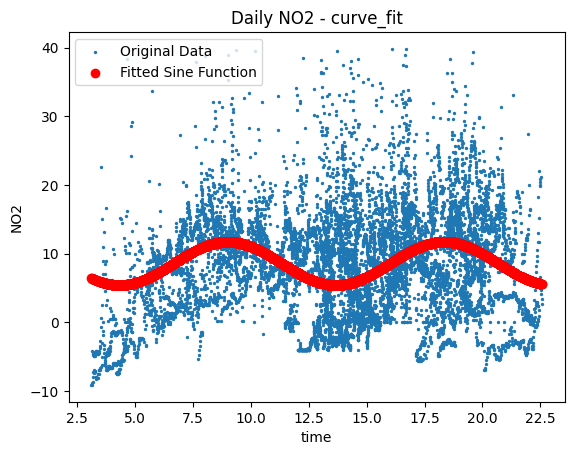

In [166]:
# Define the sine function to fit
def daily_trend(t, amplitude, frequency, phase, offset):
    t = np.array(t)
    return amplitude * np.sin(frequency * t + phase) + offset

# Fit the sine function to the data
initial_guess = (7.5, 0.8, 1, 3.5)  # Initial guess for amplitude, frequency, phase, and offset
params, covariance = curve_fit(daily_trend, filtered_time_numeric, filtered_NO2, p0=initial_guess)
print("Optimized parameters:", params)

# Generate the fitted curve
y_fit = daily_trend(filtered_time_numeric, *params)

# Calculate the residuals (difference between observed and predicted values)
residuals = filtered_NO2 - y_fit

# Calculate the sum of squared residuals
mse = np.mean(residuals**2)
print("MSE of period function generated using curve_fit:", mse)

# Plot the original data and the fitted sine function
plt.scatter(filtered_time_numeric, filtered_NO2, label='Original Data', s=2)
plt.scatter(filtered_time_numeric, y_fit, label='Fitted Sine Function', color='red')
plt.title("Daily NO2 - curve_fit")
plt.xlabel('time')
plt.ylabel('NO2')
plt.legend()
plt.show()